In [1]:
import os

import numpy as np

import torch
import torchvision
from torchvision.io import read_image

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

import ignite

from piq import BRISQUELoss, TVLoss, brisque, ssim, psnr

import cv2

import matplotlib.pyplot as plt

from utils import loss_history, plot_history

%matplotlib inline

In [2]:
path_img = './data/RealSR(V3)/canon/train/2'
images_lr = []
images_hr = []

for filename in os.listdir(path_img):
    if filename.find('LR')>0:
        images_lr.append(read_image(os.path.join(path_img, filename)).type(torch.FloatTensor))
    else:
        images_hr.append(read_image(os.path.join(path_img, filename)).type(torch.FloatTensor))

path_img = './data/RealSR(V3)/canon/test/2'
images_lr_test = []
images_hr_test = []

for filename in os.listdir(path_img):
    if filename.find('LR')>0:
        images_lr_test.append(read_image(os.path.join(path_img, filename)))
    else:
        images_hr_test.append(read_image(os.path.join(path_img, filename)))
        

In [3]:
images_lr_downscales = []
scale = 2
for image in images_lr:
    resize = torchvision.transforms.Resize((int(image.shape[1]/scale), int(image.shape[2]/scale)))
    image_downscale = resize(image)
    images_lr_downscales.append(image_downscale)
    
images_lr_downscales_test = []
scale = 2
for image in images_lr_test:
    resize = torchvision.transforms.Resize((int(image.shape[1]/scale), int(image.shape[2]/scale)))
    image_downscale = resize(image)
    images_lr_downscales_test.append(image_downscale)    

C:\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


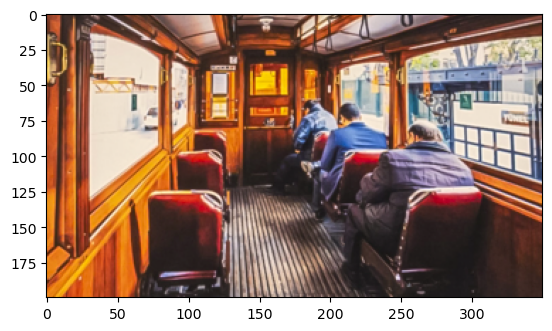

In [4]:
plt.imshow(images_lr_downscales[0].permute(1,2,0))

In [4]:
class images_dataset(Dataset):
    def __init__(self, data_source, data_target):
        self.data_source = data_source
        self.data_target = data_target
        
    def __len__(self):
        return len(self.data_source)
    
    def __getitem__(self, index):
        data_source = self.data_source[index]
        data_target = self.data_target[index]
        return data_source, data_target

In [5]:
def collate_fn(batch):
    data_source = torch.LongTensor([item[0] for item in batch])
    data_target = torch.LongTensor([item[1] for item in batch])
    return data_source, data_target

In [6]:
ds_lrdown2lr_train = images_dataset(images_lr_downscales, images_lr)
ds_lrdown2lr_test = images_dataset(images_lr_downscales_test, images_lr_test)

BATCH_SIZE = 1

dl_lrdown2lr_train = DataLoader(ds_lrdown2lr_train,
                               batch_size=BATCH_SIZE,
                               shuffle=True)#,
                               #num_workers=0,
                               #collate_fn=collate_fn)
dl_lrdown2lr_test = DataLoader(ds_lrdown2lr_test,
                               batch_size=BATCH_SIZE,
                               shuffle=True)#,
                               #num_workers=0,
                               #collate_fn=collate_fn)
dl_lrdown2lr = {'train': dl_lrdown2lr_train, 'test': dl_lrdown2lr_test}

In [7]:
class conv_block(nn.Module):
    def __init__(self, *args, **kwargs):
        super(conv_block, self).__init__()
        self.conv1 = nn.Conv2d(*args, **kwargs)
        self.bn = nn.BatchNorm2d(kwargs['out_channels'])
        self.activation = nn.GELU()
        
    def forward(self, x):
        x_input = x
        x = self.conv1(x_input)
        x = self.bn(x)
        x = self.activation(x)
        out = x + x_input
        return out
        

class lrdown2lr(nn.Module):
    def __init__(self, scale=2, n_blocks=8, channels=64):
        super().__init__()
        
        self.n_blocks = n_blocks
        self.channels = channels
        
        self.upscale = nn.Upsample(scale_factor=2)
        self.conv_in = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=channels, kernel_size=3, padding='same'),
            nn.GELU()
        )
        self.conv_inner_blocks = nn.ModuleList(conv_block(in_channels=channels,
                                     out_channels=channels,
                                     kernel_size=3,
                                     padding='same') for n in range(n_blocks))
        self.conv_out = nn.Conv2d(in_channels=channels, out_channels=3, kernel_size=3, padding='same')
    
    def forward(self, x):
        x_input = x
        x = self.upscale(x.type(torch.FloatTensor)).to(device)
        x = self.conv_in(x)
        for conv_inner in self.conv_inner_blocks:
            x = conv_inner(x)
        x = self.conv_out(x)
        out = x
        
        return out
        
        
#    def conv_block(self, channels_in, channels_out, *args, **kwargs):
#        return nn.Sequential(
#            nn.Conv2d(channels_in, channels_out, *args, **kwargs),
#            nn.BatchNorm2d(channels_out),
#            nn.GELU(),

In [8]:
class torch_trainer():
    
    def __init__(self, model, criterion, optimizer, epochs, dataloader, device='cuda', scheduler=None):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.epochs = epochs
        self.dataloader = dataloader
        self.device = device
        self.history = loss_history()
        
    
        
    def train(self):

        self.history.clear()
        loss = 0
        val_loss = 0

        for epoch in range(self.epochs):

            epoch_loss = []
            epoch_val_loss = []
            items = len(self.dataloader['train'])

            self.model.train()
            item=1
            for batch in self.dataloader['train']:
                self.optimizer.zero_grad()
                data = batch[0].to(device)
                preds = self.model(data).type(torch.FloatTensor)
                target = batch[1].to(device).type(torch.FloatTensor)
                loss = self.criterion(preds, target)
                loss.backward()
                epoch_loss.append(loss.numpy(force=True))
                self.optimizer.step()
                print (f'epoch {epoch+1}/{self.epochs}... {item}/{items}: train loss: {loss:.4f}, val_loss: {val_loss:.4f}', end='\r')
                item+=1

            items = len(self.dataloader['test'])
            self.model.eval()
            item=1
            with torch.no_grad():
                for batch in self.dataloader['test']:
                    data = batch[0].to(device)
                    preds = self.model(data)
                    target = batch[1].to(device)
                    val_loss = self.criterion(preds, target)
                    epoch_val_loss.append(val_loss.numpy(force=True))
                    print (f'epoch {epoch+1}/{self.epochs}... {item}/{items}: train loss: {loss:.4f}, val_loss: {val_loss:.4f}', end='\r')
                    item+=1

            if scheduler:
                scheduler.step(loss)
                
            loss = np.array(epoch_loss).mean()
            val_loss = np.array(epoch_val_loss).mean()

            self.history.loss.append(loss)
            self.history.val_loss.append(val_loss)
            lr = optimizer.param_groups[0]["lr"]

            print (f'epoch {epoch+1}/{self.epochs}; train loss: {loss:.4f}, val_loss: {val_loss:.4f}; lr={lr}', end='\n')

        return self.history

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print (device) 

cuda


In [110]:
model = lrdown2lr().to(device)
print(model)

lrdown2lr(
  (upscale): Upsample(scale_factor=2.0, mode='nearest')
  (conv_in): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): GELU(approximate='none')
  )
  (conv_inner_blocks): ModuleList(
    (0-7): 8 x conv_block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): GELU(approximate='none')
    )
  )
  (conv_out): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=same)
)


In [345]:
torch.cuda.empty_cache()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
trainer = torch_trainer(model=model,
                       criterion=criterion,
                       optimizer=optimizer,
                       epochs=20,
                       dataloader=dl_lrdown2lr)
history = trainer.train()

epoch 1/20; train loss: 540.5543, val_loss: 33.4849 13.750900
epoch 2/20; train loss: 28.8777, val_loss: 21.2721 19.10554999
epoch 3/20; train loss: 19.9687, val_loss: 15.9370 19.03522111


KeyboardInterrupt: 

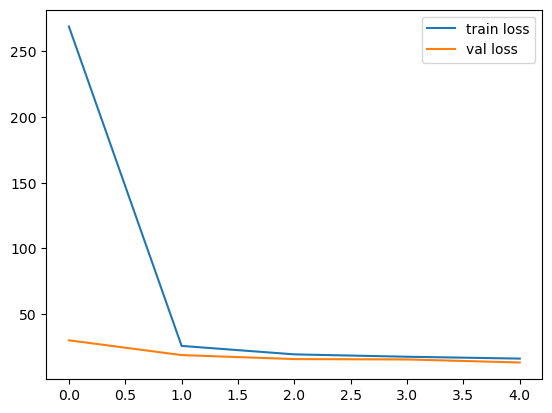

In [13]:
plot_history(history)

In [61]:
def plot_history(history):
    plt.plot(history.loss, label='train loss')
    plt.plot(history.val_loss, label='val loss')
    plt.legend()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


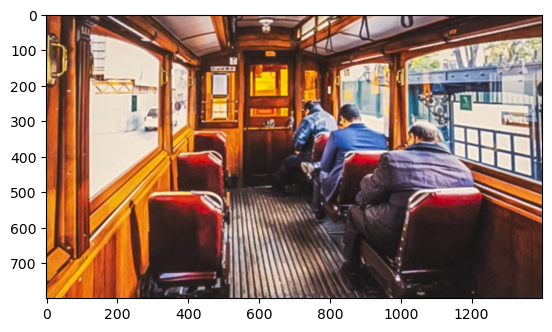

In [346]:
#test = images_lr_downscales[0]
test = images_lr[0]
test = test[None, :]
preds = model(test).type(torch.LongTensor)
img = preds[0].permute(1,2,0).detach()
to_save = (preds[0])/255.
torchvision.utils.save_image(to_save, 'test1.png')
plt.imshow(img)

In [16]:
to_save = (preds[0])/255.
torchvision.utils.save_image(to_save, 'test.png')

In [20]:
torch.cuda.empty_cache()

In [59]:
optimizer.param_groups[0]["lr"]

1e-05

In [15]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [25]:
torchvision.utils.save_image(images_lr_downscales[0]/255., 'test2.png')

# deblur

In [17]:
class nn_deblur(nn.Module):
    def __init__(self, n_channels):
        super(nn_deblur, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=n_channels, kernel_size=(3,3), stride=1, padding='same'),
            nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=(5,5), stride=1, padding='same'),
            #nn.Conv2d(in_channels=n_channels, out_channels=3, kernel_size=(7,7), stride=1, padding='same'),
            #nn.Conv2d(in_channels=n_channels, out_channels=3, kernel_size=(11,11), stride=1, padding='same')
        )
        self.conv_resc1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(1,1), padding='same')
        
        #self.conv2 = nn.Sequential(
        #    nn.Conv2d(in_channels=3, out_channels=n_channels, kernel_size=(3,3), stride=1, padding='same'),
        #    nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=(5,5), stride=1, padding='same'),
        #    nn.Conv2d(in_channels=n_channels, out_channels=3, kernel_size=(7,7), stride=1, padding='same'),
            #nn.Conv2d(in_channels=n_channels, out_channels=3, kernel_size=(11,11), stride=1, padding='same')
        #)
        #self.conv_resc2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(1,1), padding='same')
        
        self.act = nn.GELU()
        
    def forward(self, x):
        x = x.type(torch.cuda.FloatTensor)
        x = self.conv1(x) + self.conv_resc1(x)
        #x = self.conv2(x) + self.conv_resc2(x)
        x = self.act(x)
        x = torch.clamp(x, min=0, max=255)
        return x

In [18]:
class nn_deblur_v1(nn.Module):
    def __init__(self, n_channels):
        super(nn_deblur_v1, self).__init__()
        
        self.conv_in = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(1,1), stride=1, padding='same')
        
        self.conv3x3 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(3,3), stride=1, padding='same')
        self.conv5x5 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(5,5), stride=1, padding='same')
        #self.conv7x7 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(7,7), stride=1, padding='same')
        #self.conv11x11 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(11,11), stride=1, padding='same')
        
        self.conv_out = nn.Conv2d(in_channels=6, out_channels=3, kernel_size=(1,1), stride=1, padding='same')
        self.conv_resc1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(1,1), padding='same')
        
        self.act = nn.GELU()
        
    def forward(self, x):
        x = x.type(torch.cuda.FloatTensor)
        x_input = x
        #x = self.conv_in(x)
        
        x_3x3 = self.conv3x3(x)
        x_5x5 = self.conv5x5(x)
        #x_7x7 = self.conv7x7(x)
        #x_11x11 = self.conv11x11(x)
        
        x = torch.cat((x_3x3, x_5x5), 1) #, x_7x7, x_11x11), 1)

        x = self.conv_out(x) + self.conv_resc1(x_input)
        x = self.act(x)
        x = torch.clamp(x, min=0, max=255)

        return x

In [19]:
ds_deblur_train = images_dataset(images_lr[:1], images_lr[:1])
ds_deblur_test = images_dataset(images_lr_test[:1], images_lr_test[:1])

BATCH_SIZE = 1

dl_deblur_train = DataLoader(ds_deblur_train,
                               batch_size=BATCH_SIZE,
                               shuffle=False)
dl_deblur_test = DataLoader(ds_deblur_test,
                               batch_size=BATCH_SIZE,
                               shuffle=False)

dl_deblur = {'train': dl_deblur_train, 'test': dl_deblur_test}

ds_deblur_withscale = images_dataset(images_lr_downscales[:10], images_lr[:10])
dl_deblur_withscale = DataLoader(ds_deblur_withscale,
                               batch_size=BATCH_SIZE,
                               shuffle=False)

dl_deblur_withscale = {'train': dl_deblur, 'test': dl_deblur_test}

In [23]:
model_deblur = nn_deblur(3).to(device)
print(model_deblur)

def loss_brisque(y_pred, y_true):
    loss = BRISQUELoss(data_range=255)
    loss = loss(y_pred) #+ 0.01*nn.L1Loss()(y_pred, y_true)

    return loss


def loss_tv(y_pred, y_true):
    loss = TVLoss()(y_pred)
    loss = 10000/loss + 0.01*nn.L1Loss()(y_pred, y_true)
    return loss

def loss_agm(y_pred, y_true):
    y = y_pred[0]
    gy, gx, gc = torch.gradient(y)
    gnorm = torch.sqrt(gx**2 + gy**2)
    return torch.mean(gnorm) #+ nn.MSELoss()(y_pred, y_true)

def loss_fft(y_pred, y_true):
    return 1/(tensor2freq(y_pred)+1e-10) #+ 0.01*nn.L1Loss()(y_pred, y_true)

def loss_tv_psnr(y_pred, y_true):
    loss_tv = TVLoss()(y_pred)
    loss_tv = 10000/loss_tv
    loss_psnr = psnr(y_pred, y_true, data_range=255, convert_to_greyscale=True)
    loss_psnr = 100 - loss_psnr
    return loss_tv + 0.01*loss_psnr + 0.01*nn.L1Loss()(y_pred, y_true)

def loss_tv_ssim(y_pred, y_true):
    loss_tv = TVLoss()(y_pred)
    loss_tv = 10000/loss_tv
    loss_ssim = ssim(y_pred, y_true, data_range=255)
    loss_ssim = 1 - loss_psnr
    return loss_tv + 0.1*loss_ssim #+ 0.01*nn.L1Loss()(y_pred, y_true)

criterion_deblur = loss_brisque
optimizer = torch.optim.AdamW(model_deblur.parameters(), lr=1e-3)
#exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.5, patience=3,min_lr=1e-5)
trainer = torch_trainer(model=model_deblur,
                       criterion=criterion_deblur,
                       optimizer=optimizer,
                       epochs=100,
                       dataloader=dl_deblur)
history = trainer.train()


nn_deblur(
  (conv1): Sequential(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): Conv2d(3, 3, kernel_size=(5, 5), stride=(1, 1), padding=same)
  )
  (conv_resc1): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1), padding=same)
  (act): GELU(approximate='none')
)
epoch 1/100; train loss: 48.6452, val_loss: 78.9367; lr=0.001
epoch 2/100; train loss: 48.6472, val_loss: 79.0280; lr=0.001
epoch 3/100; train loss: 48.6522, val_loss: 79.0305; lr=0.001
epoch 4/100; train loss: 48.6475, val_loss: 79.0309; lr=0.001
epoch 5/100; train loss: 48.6443, val_loss: 79.0334; lr=0.0005
epoch 6/100; train loss: 48.6572, val_loss: 79.0334; lr=0.0005
epoch 7/100; train loss: 48.6552, val_loss: 79.0353; lr=0.0005
epoch 8/100; train loss: 48.6542, val_loss: 79.0358; lr=0.0005
epoch 9/100; train loss: 48.6573, val_loss: 79.0334; lr=0.00025
epoch 10/100; train loss: 48.6469, val_loss: 79.0324; lr=0.00025
epoch 11/100; train loss: 48.6616, val_loss: 79.0295; lr=0.00025
epoch 12/100

In [ ]:
model_deblur = nn_deblur(3).to(device)
print(model_deblur)

def loss_brisque(y_pred, y_true):
    loss = BRISQUELoss(data_range=255)(y_pred)
    loss = 100/loss #+ 0.01*nn.L1Loss()(y_pred, y_true)

    return loss

def loss_tv(y_pred, y_true):
    loss = TVLoss()(y_pred)
    loss = 10000/loss + 0.005*nn.L1Loss()(y_pred, y_true)
    return loss

def loss_agm(y_pred, y_true):
    y = y_pred[0]
    gy, gx, gc = torch.gradient(y)
    gnorm = torch.sqrt(gx**2 + gy**2)
    return torch.mean(gnorm) #+ nn.MSELoss()(y_pred, y_true)

def loss_fft(y_pred, y_true):
    return 1/(tensor2freq(y_pred)+1e-10) #+ 0.01*nn.L1Loss()(y_pred, y_true)

def loss_tv_psnr(y_pred, y_true):
    loss_tv = TVLoss()(y_pred)
    loss_tv = 10000/loss_tv
    loss_psnr = psnr(y_pred, y_true, data_range=255, convert_to_greyscale=True)
    loss_psnr = 100 - loss_psnr
    return loss_tv + 0.01*loss_psnr + 0.01*nn.L1Loss()(y_pred, y_true)

def loss_tv_ssim(y_pred, y_true):
    loss_tv = TVLoss()(y_pred)
    loss_tv = 10000/loss_tv
    loss_ssim = ssim(y_pred, y_true, data_range=255)
    loss_ssim = 1 - loss_psnr
    return loss_tv + 0.1*loss_ssim #+ 0.01*nn.L1Loss()(y_pred, y_true)

criterion_deblur = loss_tv
optimizer = torch.optim.AdamW(model_deblur.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.5, patience=3,min_lr=1e-5)
trainer = torch_trainer(model=model_deblur,
                       criterion=criterion_deblur,
                       optimizer=optimizer,
                       epochs=5000,
                       dataloader=dl_deblur)
history = trainer.train()


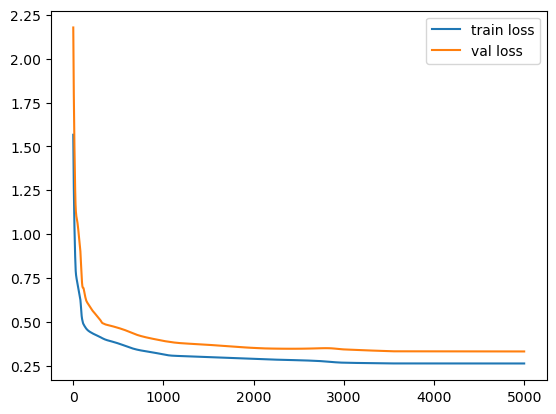

In [83]:
plot_history(history)

tensor(0.8423) tensor(0.9263)


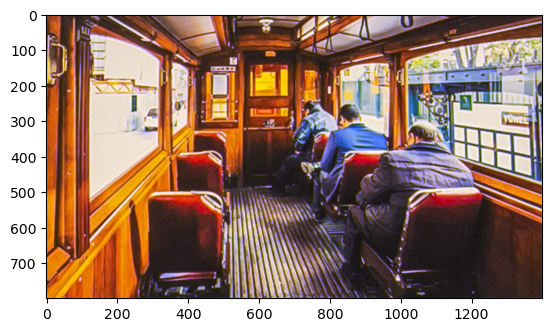

In [84]:
#test = images_lr[0]
test = read_image('out_before.png')
test = test[None, :]
model_deblur.eval()
with torch.no_grad():
    preds = model_deblur(test).type(torch.LongTensor)
img = preds[0].permute(1,2,0).detach()
to_save = (preds[0])/255.
torchvision.utils.save_image(to_save, 'out.png')
plt.imshow(img)

ref = images_hr[0]
ref = ref[None, :]
ssim_after = ssim(preds, ref, data_range=255)
ssim_before = ssim(test, ref, data_range=255)
print(ssim_after, ssim_before)

In [439]:
torch.save(model_deblur, 'ssim09282_1000epochs')
torch.save({
            'epoch': 1000,
            'model_state_dict': model_deblur.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion_deblur
            }, 'torch_ssim09282_1000epochs')

In [422]:
images_lr[0]

tensor([[[0.4980, 0.5686, 0.6078,  ..., 0.1961, 0.2039, 0.2078],
         [0.4941, 0.5529, 0.5804,  ..., 0.2157, 0.2196, 0.2235],
         [0.5059, 0.5529, 0.5725,  ..., 0.2706, 0.2824, 0.2941],
         ...,
         [0.9490, 0.9608, 0.9412,  ..., 0.2471, 0.2431, 0.2353],
         [0.9608, 0.9490, 0.9255,  ..., 0.2431, 0.2431, 0.2353],
         [0.9412, 0.9137, 0.9020,  ..., 0.2431, 0.2431, 0.2431]],

        [[0.2549, 0.2941, 0.3020,  ..., 0.1529, 0.1529, 0.1529],
         [0.2353, 0.2706, 0.2784,  ..., 0.1529, 0.1490, 0.1412],
         [0.2235, 0.2510, 0.2627,  ..., 0.1686, 0.1686, 0.1725],
         ...,
         [0.5490, 0.5686, 0.5490,  ..., 0.1608, 0.1569, 0.1490],
         [0.5608, 0.5529, 0.5333,  ..., 0.1608, 0.1569, 0.1529],
         [0.5333, 0.5137, 0.5020,  ..., 0.1608, 0.1608, 0.1647]],

        [[0.1451, 0.1725, 0.1843,  ..., 0.1412, 0.1451, 0.1529],
         [0.1569, 0.1882, 0.1922,  ..., 0.1294, 0.1333, 0.1333],
         [0.1647, 0.1922, 0.1961,  ..., 0.1373, 0.1451, 0.

In [76]:
images_lr[0][0].numpy().shape

(400, 700)

In [79]:
lr = images_lr_downscales[0][0].numpy()
hr = images_hr[0][0].numpy()

gy, gx = np.gradient(lr)
gnorm = np.sqrt(gx**2 + gy**2)
print(np.average(gnorm))

gy, gx = np.gradient(hr)
gnorm = np.sqrt(gx**2 + gy**2)
print(np.average(gnorm))

21.01626905868889
10.95381203369981


In [88]:
lr = images_lr_downscales[0].type(torch.FloatTensor)
hr = images_hr[0].type(torch.FloatTensor)

gy, gx, gc = torch.gradient(lr)
gnorm = torch.sqrt(gx**2 + gy**2 + gc**2)
print(torch.mean(gnorm))

gy, gx, gc = np.gradient(hr)
gnorm = np.sqrt(gx**2 + gy**2 + gc**2)
print(np.average(gnorm))

tensor(40.4811)
34.710903


In [180]:
trainer.loss.grad

In [268]:
def dft_amp(img):
    fft_im = torch.fft.rfft( img, signal_ndim=2, onesided=False )
    fft_amp = fft_im[:,:,:,:,0]**2 + fft_im[:,:,:,:,1]**2
    return torch.sqrt(fft_amp)

dft_amp(images_lr[0])

TypeError: fft_rfft() got an unexpected keyword argument 'signal_ndim'

In [276]:
torch.fft.rfft(images_hr[0]).shape

torch.Size([3, 800, 701])

In [292]:
def tensor2freq(x):
    # crop image patches
    patch_factor = 1
    _, _, h, w = x.shape
    assert h % patch_factor == 0 and w % patch_factor == 0, (
        'Patch factor should be divisible by image height and width')
    patch_list = []
    patch_h = h // patch_factor
    patch_w = w // patch_factor
    for i in range(patch_factor):
        for j in range(patch_factor):
            patch_list.append(x[:, :, i * patch_h:(i + 1) * patch_h, j * patch_w:(j + 1) * patch_w])

        # stack to patch tensor
    y = torch.stack(patch_list, 1)

    # perform 2D DFT (real-to-complex, orthonormalization)
    freq = torch.fft.fft2(y, norm='ortho')
    freq = torch.stack([freq.real, freq.imag], -1)
    
    return freq.mean()


In [293]:
test = images_lr[0]
test = test[None, :]
tensor2freq(test)

tensor(0.0721)

In [4]:
def getSharpness(images):
    sharpness_vals = []
    derivative_imgs = []
    for img in images:
        derivative = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
        derivative_imgs.append(derivative)
        sharpness_vals.append(cv2.norm(derivative))
    return derivative_imgs, sharpness_vals

In [19]:
images_np = np.array(images_lr[0])
a, b = getSharpness(images_np)

In [42]:
b

[924742.4838478008, 804595.2767317243, 728193.959805353]

In [36]:
a

[array([[   0.,  908.,  760., ...,  150.,  136.,    0.],
        [   0.,  842.,  656., ...,  227.,  185.,    0.],
        [   0.,  751.,  504., ...,  409.,  316.,    0.],
        ...,
        [   0., -190., -472., ...,  -66.,  -76.,    0.],
        [   0., -343., -505., ...,  -78.,  -74.,    0.],
        [   0., -388., -478., ...,  -80.,  -66.,    0.]]),
 array([[   0.,  346.,   94., ...,  -16.,  -46.,    0.],
        [   0.,  362.,  129., ...,   20.,   -4.,    0.],
        [   0.,  410.,  196., ...,  150.,  141.,    0.],
        ...,
        [   0., -124., -482., ...,  -58.,  -70.,    0.],
        [   0., -283., -510., ...,  -72.,  -65.,    0.],
        [   0., -330., -486., ...,  -74.,  -54.,    0.]]),
 array([[   0.,  276.,   24., ...,   74.,  100.,    0.],
        [   0.,  278.,   15., ...,  134.,  152.,    0.],
        [   0.,  309.,   18., ...,  307.,  312.,    0.],
        ...,
        [   0., -101., -523., ...,  -69.,  -76.,    0.],
        [   0., -308., -626., ...,  -87.,  -9

In [18]:
torch_sobel = Sobel()

In [38]:
images_tensor = torch.FloatTensor(np.array(images_lr[:1]))
im_gr = torchvision.transforms.Grayscale()(images_tensor)
print(im_gr.shape)
derivs = torch_sobel(im_gr)
derivs

torch.Size([1, 1, 400, 700])


tensor([[[[124.3786,  65.1107,  70.5449,  ...,  55.6721,  64.9517,  68.5075],
          [110.8581,  22.6103,  26.8387,  ..., 168.0509, 195.4942, 243.8969],
          [119.5695,  33.0675,  40.2347,  ..., 320.4005, 336.0049, 361.7405],
          ...,
          [ 73.6868,  53.7021, 105.2892,  ...,   0.8454,   4.0844,  14.1444],
          [  1.1179,  93.7471, 108.4399,  ...,   2.1554,   7.5163,  18.8298],
          [ 91.5316, 105.1587,  86.2123,  ...,   9.7318,  11.0912,  16.1775]]]])

In [43]:
torch.linalg.norm(derivs)

tensor(165562.7188)

In [70]:
loss_sobel(images_tensor, None)

tensor(165562.7188, device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


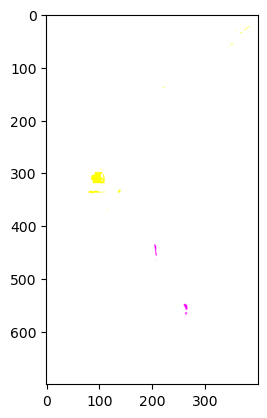

In [163]:
images_tensor = torch.FloatTensor(np.array(images_lr[0]))
blur = torchvision.transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.))(images_tensor)
plt.imshow(blur.T)
torchvision.utils.save_image(blur, 'test1_blur.png')

In [ ]:
class Sobel(nn.Module):
    def __init__(self):
        super().__init__()
        self.filter = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3, stride=1, padding=0, bias=False)

        Gx = torch.tensor([[2.0, 0.0, -2.0], [4.0, 0.0, -4.0], [2.0, 0.0, -2.0]])
        Gy = torch.tensor([[2.0, 4.0, 2.0], [0.0, 0.0, 0.0], [-2.0, -4.0, -2.0]])
        G = torch.cat([Gx.unsqueeze(0), Gy.unsqueeze(0)], 0)
        G = G.unsqueeze(1)
        self.filter.weight = nn.Parameter(G, requires_grad=True)

    def forward(self, img):
        x = self.filter(img)
        x = torch.mul(x, x)
        x = torch.sum(x, dim=1, keepdim=True)
        x = torch.sqrt(x)
        return x
    
def loss_sobel(y_pred, y_true):
    torch_sobel = Sobel()
    grayscale = torchvision.transforms.Grayscale()(y_pred)
    out = torch.linalg.norm(torch_sobel(grayscale))
    print(out)
    return 1/out    

In [262]:
ignite.============

[tensor([[[[127, 145, 155,  ...,  50,  52,  53],
          [126, 141, 148,  ...,  55,  56,  57],
          [129, 141, 146,  ...,  69,  72,  75],
          ...,
          [242, 245, 240,  ...,  63,  62,  60],
          [245, 242, 236,  ...,  62,  62,  60],
          [240, 233, 230,  ...,  62,  62,  62]],

         [[ 65,  75,  77,  ...,  39,  39,  39],
          [ 60,  69,  71,  ...,  39,  38,  36],
          [ 57,  64,  67,  ...,  43,  43,  44],
          ...,
          [140, 145, 140,  ...,  41,  40,  38],
          [143, 141, 136,  ...,  41,  40,  39],
          [136, 131, 128,  ...,  41,  41,  42]],

         [[ 37,  44,  47,  ...,  36,  37,  39],
          [ 40,  48,  49,  ...,  33,  34,  34],
          [ 42,  49,  50,  ...,  35,  37,  40],
          ...,
          [ 32,  40,  36,  ...,  36,  34,  34],
          [ 39,  38,  33,  ...,  36,  35,  33],
          [ 39,  31,  27,  ...,  37,  36,  36]]]], dtype=torch.uint8), tensor([[[[127, 145, 155,  ...,  50,  52,  53],
          [126,